<a href="https://colab.research.google.com/github/Dipolar-Quantum-Gases/nn-beam-profiling/blob/master/Neural_Network_Beam_Profiling_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Detectron2 to profile laser beams 

<img src="https://github.com/Dipolar-Quantum-Gases/nn-beam-profiling/blob/master/imgs/thumbnail.jpg?raw=true" alt="drawing" width="150"/> <img src="https://github.com/Dipolar-Quantum-Gases/nn-beam-profiling/blob/master/imgs/thumbnailexp.png?raw=true" alt="drawing" width="150"/>

This notebook demonstrates how to train a deep neural network to detect and profile multiple laser beams in a single image. This is based off the paper "Measuring Laser Beams with a Neural Network" which can be found in both [ArXiv](https://arxiv.org/abs/2202.07801) and [published versions](https://doi.org/10.1364/AO.443531).

##Package Installation

### Install Detectron2

Detectron2 installation needs to match the PyTorch and CUDA versions on Colab's virtual machine.

In [1]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 65.6 MB/s 
     |████████████████████████████████| 74 kB 2.9 MB/s 
     |████████████████████████████████| 130 kB 15.5 MB/s 
     |████████████████████████████████| 49 kB 3.1 MB/s 
     |████████████████████████████████| 145 kB 53.8 MB/s 
     |████████████████████████████████| 748 kB 49.2 MB/s 
     |████████████████████████████████| 843 kB 51.8 MB/s 
     |████████████████████████████████| 596 kB 61.8 MB/s 
     |████████████████████████████████| 112 kB 71.8 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220212-py3-none-any.whl size=61216 sha256=ac2edd71ee58a295e6f467fcfc8c8c6e784ed9c0ad1620e3f097843445b0f0dd
  Stored in directory: /root/.cache/pip/wheels/92/43/75/238d2a5d897274799f92b8938f3cd807a3ccd3c8f37c0a4725
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=95

###Clone Github repository
Let's clone the Github repo so we can use the code in the Colab notebook. 

In [2]:
!git clone https://github.com/Dipolar-Quantum-Gases/nn-beam-profiling

Cloning into 'nn-beam-profiling'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 32 (delta 7), reused 26 (delta 3), pack-reused 0
Unpacking objects: 100% (32/32), done.


##Laser beam datasets

Their are two datasets used in the paper. The first is a simulated dataset comprised of 5000 images and the second is an experimental dataset with 1050 images created using a spatial light modulator. These are both located in an [University of Oxford Research Archive](https://ora.ox.ac.uk/objects/uuid:e7f9ee4c-5b07-469f-979c-73b8a28d7ec2) from which they can be downloaded as .zip files.

For more information on the dataset, we have a [Colab notebook](https://colab.research.google.com/github/Dipolar-Quantum-Gases/nn-beam-profiling/blob/master/Explore_the_Dataset.ipynb) which shows to inspect and visualize the two datasets

###Download the dataset

Here we download and unzip either the experimental or simulation dataset. Note the simulation dataset is 10x the size of the experimental dataset and can take a significant amount of time to download.

In [3]:
from pathlib import Path
import sys
sys.path.append('/content/nn-beam-profiling/nn-beam-profiling')
from dataset_extraction import dataset_extractor

#the .zip urls of the two datasets
dataset_urls = {'experimental_data': "https://ora.ox.ac.uk/objects/uuid:e7f9ee4c-5b07-469f-979c-73b8a28d7ec2/download_file?safe_filename=experimental_data.zip&type_of_work=Dataset",
                'simulation_data': "https://ora.ox.ac.uk/objects/uuid:e7f9ee4c-5b07-469f-979c-73b8a28d7ec2/download_file?safe_filename=simulation_data.zip&type_of_work=Dataset"}

zip_dir = Path('/content/data/datasets/compressed_data')
unzip_dir = Path('/content/data/datasets')
dataset = 'experimental_data'
# dataset = 'simulation_data'

url = dataset_urls[dataset]
dataset_extractor(dataset, url, zip_dir, unzip_dir)

Here we get the paths to the different parts of the dataset including the annotations (text_path), the rgb images (img_path) and the top level directory (dataset_path).

In [4]:
def get_paths(dataset, local_data_path):
  dataset_path = local_data_path /  dataset
  text_path = dataset_path / 'text'
  img_path = dataset_path / 'imgs'
  return dataset_path, text_path, img_path

dataset_path, text_path, img_path = get_paths(dataset, unzip_dir)

###Create Detectron2 dataset

Now we define a dataset class for our custom laser beam datasets. The dataframe file holds all the annotation information including boxes, rotated boxes, masks and keypoints. However here we focus on the rotated boxes.

In [5]:
import detectron2
import pandas as pd
from detectron2.structures import BoxMode

class BeamDataset():

    def __init__(self, dataset_path, text_path, scalar=1):
        self.dataset_path = dataset_path
        self.text_path = text_path
        self.box_name = 'abox_' + str(scalar)


    def training_dataset(self):
        return self.get_dataset_list()


    def validation_dataset(self):
        return self.get_dataset_list(False)


    def read_DF(self, train):
        if train:
          self.data = pd.read_json(str(self.text_path) + '/data_train.json')
        else:
          self.data = pd.read_json(str(self.text_path) + '/data_val.json')
          

    def get_dataset_list(self, train=True):
        self.read_DF(train)
        # dlist = []
        dlist = [self.getitem(i, train) for i in range(len(self.data))]
        # length = len(self.data)
        # for i in range(0, length):
        #   dlist.append(self.getitem(i, train))
        return dlist


    def dataset_length(self, train=True):
        self.read_DF(train)
        return len(self.data)
      

    def getitem(self, idx, train=True):
        # load images and ROI boxes
        idata = self.data.loc[idx]
        aboxes = idata[self.box_name]
        labels = idata['label']
        annotations = []
        for abox, label in zip(aboxes, labels): # get bounding box coordinates and fits for each mask
            annotation_dict = {}
            annotation_dict['bbox'] = [float(val) for val in abox]
            annotation_dict['bbox_mode'] = BoxMode.XYWHA_ABS 
            annotation_dict['category_id'] = label - 1
            annotation_dict['iscrowd'] = 0
            annotations.append(annotation_dict)
        
        image_dict = {}
        image_dict['annotations'] = annotations
        file_name = str(self.dataset_path) + idata['rgb_paths'].replace('\\', '/')
        image_dict['file_name'] = file_name
        image_dict['image_id'] = int(idata['run'])
        image_dict['height'] = idata['height']
        image_dict['width'] = idata['width']
        
        return image_dict

### Registering the dataset

Detectron2 requires us to register our datasets and their metadata before we can use them. This is done for both the training and validation datsets in the code below.

In [6]:
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog

def register_dataset_metadata(dataset_name, dataset_function, class_names):
  if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)
    MetadataCatalog.remove(dataset_name)
  DatasetCatalog.register(dataset_name, dataset_function)
  MetadataCatalog.get(dataset_name).thing_classes = class_names


train_dataset = 'train_dataset'
val_dataset = 'val_dataset'
dataset_scalar = 1.5
class_names = ["Gaussian"]
acd = BeamDataset(dataset_path, text_path, scalar=dataset_scalar)
register_dataset_metadata(train_dataset, acd.training_dataset, class_names)
register_dataset_metadata(val_dataset, acd.validation_dataset, class_names)

###Visualize the dataset

Here we randomly visualize some of the validation dataset images along with their annotations for rotated regions-of-interest.



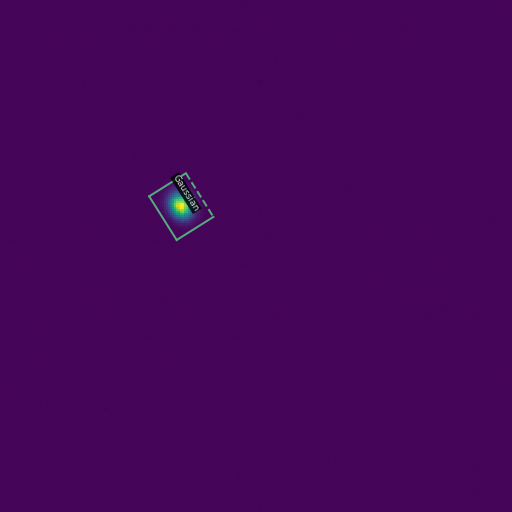

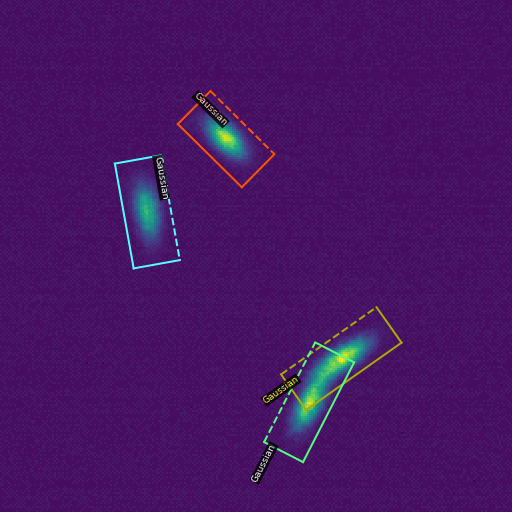

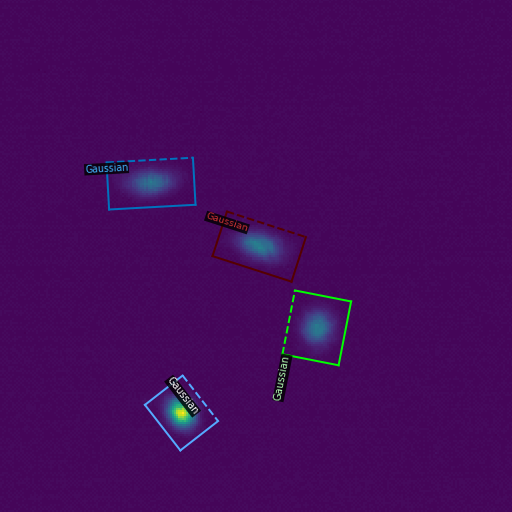

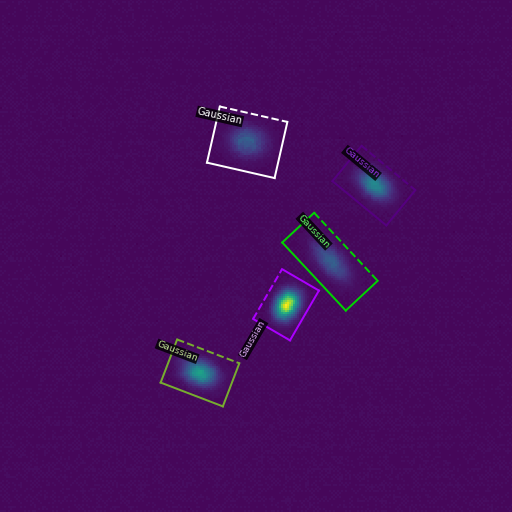

In [7]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from google.colab.patches import cv2_imshow


def get_dataset_info(dataset_name):
  dataset_metadata = MetadataCatalog.get(dataset_name)
  dataset_dicts = DatasetCatalog.get(dataset_name)
  return dataset_metadata, dataset_dicts


def visualize_dataset(dataset_metadata, dataset_dicts, num_samples=5, scale = 2):
  dlength = len(dataset_dicts)
  if num_samples > dlength:
    num_samples = dlength
  for d in random.sample(dataset_dicts, num_samples):
      img = cv2.imread(d["file_name"])
      visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata, scale=scale)
      vis = visualizer.draw_dataset_dict(d)
      cv2_imshow(vis.get_image()[:, :, ::-1])


training_dataset_metadata, training_dataset_dicts = get_dataset_info(train_dataset)
visualize_dataset(training_dataset_metadata, training_dataset_dicts, num_samples=2)

val_dataset_metadata, val_dataset_dicts = get_dataset_info(val_dataset)
visualize_dataset(val_dataset_metadata, val_dataset_dicts, num_samples=2)

##Neural network model 

Rather than building the model explicitly in PyTorch, we modify a config file (CFG) to define the neural network we want built. Once we enter the training loop, Detectron2 will build the neural network model according to the CFG specifications.

In [8]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()

# get_base_model_and_weights
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# setup_rpn_head
cfg.MODEL.PROPOSAL_GENERATOR.NAME = "RRPN"
cfg.MODEL.RPN.HEAD_NAME = "StandardRPNHead"
cfg.MODEL.RPN.BBOX_REG_WEIGHTS = (1, 1, 1, 1, 1)

# setup_anchor_generator
cfg.MODEL.ANCHOR_GENERATOR.NAME = "RotatedAnchorGenerator"
cfg.MODEL.ANCHOR_GENERATOR.ANGLES = [[-60,-30,0,30,60,90]]

# Setup RROI heads
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .5  
cfg.MODEL.ROI_HEADS.NAME = "RROIHeads"
cfg.MODEL.ROI_BOX_HEAD.POOLER_TYPE = "ROIAlignRotated"
cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS = (1, 1, 1, 1, 1)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256 

cfg.MODEL.MASK_ON = False
cfg.DATALOADER.NUM_WORKERS = 2

##Train

###Custom Detectron2 trainer

The default Detectron2 trainer doesn't work for rotated regions-of-interest so we write a custom trainer. This trainer needs a custom data mapper to be implemented in both the training and test loader. 

Additionally, the evaluation between training epochs must be done with the Rotated COCO evaluator.

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader
from detectron2.data import transforms as T
from detectron2.evaluation import DatasetEvaluators, RotatedCOCOEvaluator
from rotation_mapper import MyDatasetMapper


class MyTrainer(DefaultTrainer):
  def __init__(self, cfg):
    super().__init__(cfg)


  @classmethod
  def build_evaluator(self, cfg, dataset_name, output_folder=None):
      if output_folder is None:
          output_folder = cfg.OUTPUT_DIR + '/coco_eval/' + dataset_name
          os.makedirs(output_folder, exist_ok=True)
      evaluators = [RotatedCOCOEvaluator(dataset_name, cfg, True, output_folder)]
      return DatasetEvaluators(evaluators)


  @classmethod
  def build_train_loader(cls, cfg, hf=False, height=800, width=800):
    augmentations = T.AugmentationList([T.Resize((height, width))])
    return build_detection_train_loader(cfg, mapper=MyDatasetMapper(cfg, True, 
                                                                    augmentations))


  @classmethod
  def build_test_loader(cls, cfg, dataset, height=800, width=800):
    augmentations = T.AugmentationList([T.Resize((height, width))])
    return build_detection_test_loader(cfg, dataset, mapper=MyDatasetMapper(cfg, 
                                                                            False, 
                                                                            augmentations))

###Set training parameters

Here we set the hyperparameters for training the neural network including batch size, learning rate, learning rate scheduler, momentum and training epochs. 

Detectron2 uses iterations (number of batches passed through the NN) rather than training epochs so we need to convert between the two.

In [10]:
from math import ceil

def get_learning_rate_schedule(lrs_iters, train_iters):
    max_steps = int(ceil(train_iters / lrs_iters))
    schedule = [lrs_iters * (i + 1) - 1 for i in range(0, max_steps)]
    return schedule


def epochs_to_iterations(epochs, num_imgs, batch_size):
    return int(epochs * (num_imgs / batch_size))

# define the parameters for training
train_epochs = 2
eval_epochs = 1
batch_size = 4
lrs_step = 10
num_imgs = len(DatasetCatalog.get(train_dataset))

# convert epochs to iterations
train_iters = epochs_to_iterations(train_epochs, num_imgs, batch_size)  
eval_iters = epochs_to_iterations(eval_epochs, num_imgs, batch_size) 
lrs_iters = epochs_to_iterations(lrs_step, num_imgs, batch_size) 
lrs_schedule = get_learning_rate_schedule(lrs_iters, train_iters)

# set training hyperparameters in the config file
cfg.SOLVER.IMS_PER_BATCH = batch_size
cfg.SOLVER.BASE_LR = 0.01
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.GAMMA = .01
cfg.SOLVER.STEPS = lrs_schedule
cfg.SOLVER.WARMUP_ITERS = 0
cfg.SOLVER.MAX_ITER = train_iters    
cfg.TEST.EVAL_PERIOD = eval_iters 

# set training and validation datasets 
cfg.DATASETS.TRAIN = (train_dataset,)
cfg.DATASETS.TEST = (val_dataset,)

###Train the neural network

Now we create folder for all the training/evaluation results and start the training loop. The custom trainer we defined earlier will construct the neural network according to the CFG file and then start the training loop with the hyperparameters also defined in the CFG file.

In [11]:
import os
import shutil
import time

def make_output_dir(dataset, base_dir):
  output_dir = base_dir + '/' + dataset + '/' + time.strftime('%H''%M''_''%d''%m''%Y')
  cfg.OUTPUT_DIR = output_dir
  if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)
  os.makedirs(output_dir, exist_ok=True)

make_output_dir(dataset, '/content/training_output')
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/18 16:47:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:11, 16.1MB/s]                           
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (18, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.bias' to the model due to incompatible shapes: (3,) in the checkpoint but (18,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.weight' to the model due to incompatible shapes: (12, 256, 1, 1) in the checkpoint but (90, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.bias' to the model due to incompatible shapes: (12,) in the checkpoint but (90,) in the model! You might want to double check if this is expected.
Skip loading parameter 

[02/18 16:47:39 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/detectron2/structures/rotated_boxes.py:214: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = torch.as_tensor(tensor, dtype=torch.float32, device=device)
/usr/local/lib/python3.7/dist-packages/detectron2/structures/rotated_boxes.py:214: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = torch.as_tensor(tensor, dtype=torch.float32, device=device)
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of py

[02/18 16:47:55 d2.utils.events]:  eta: 0:05:02  iter: 19  total_loss: 0.7389  loss_cls: 0.2823  loss_box_reg: 0.2755  loss_rpn_cls: 0.04879  loss_rpn_loc: 0.07831  time: 0.7981  data_time: 0.0310  lr: 0.01  max_mem: 3160M
[02/18 16:48:12 d2.utils.events]:  eta: 0:04:52  iter: 39  total_loss: 0.557  loss_cls: 0.1945  loss_box_reg: 0.2313  loss_rpn_cls: 0.03886  loss_rpn_loc: 0.07237  time: 0.8085  data_time: 0.0247  lr: 0.01  max_mem: 3160M
[02/18 16:48:28 d2.utils.events]:  eta: 0:04:37  iter: 59  total_loss: 0.3771  loss_cls: 0.1116  loss_box_reg: 0.1998  loss_rpn_cls: 0.01954  loss_rpn_loc: 0.04739  time: 0.8125  data_time: 0.0213  lr: 0.01  max_mem: 3160M
[02/18 16:48:45 d2.utils.events]:  eta: 0:04:21  iter: 79  total_loss: 0.3211  loss_cls: 0.1004  loss_box_reg: 0.1796  loss_rpn_cls: 0.01092  loss_rpn_loc: 0.03783  time: 0.8179  data_time: 0.0240  lr: 0.01  max_mem: 3160M
[02/18 16:49:01 d2.utils.events]:  eta: 0:04:05  iter: 99  total_loss: 0.301  loss_cls: 0.09124  loss_box_reg

/usr/local/lib/python3.7/dist-packages/detectron2/structures/rotated_boxes.py:214: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = torch.as_tensor(tensor, dtype=torch.float32, device=device)
/usr/local/lib/python3.7/dist-packages/detectron2/structures/rotated_boxes.py:214: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = torch.as_tensor(tensor, dtype=torch.float32, device=device)


[02/18 16:50:25 d2.evaluation.evaluator]: Inference done 11/250. Dataloading: 0.0021 s/iter. Inference: 0.0654 s/iter. Eval: 0.0001 s/iter. Total: 0.0677 s/iter. ETA=0:00:16
[02/18 16:50:30 d2.evaluation.evaluator]: Inference done 86/250. Dataloading: 0.0025 s/iter. Inference: 0.0642 s/iter. Eval: 0.0001 s/iter. Total: 0.0669 s/iter. ETA=0:00:10
[02/18 16:50:35 d2.evaluation.evaluator]: Inference done 162/250. Dataloading: 0.0026 s/iter. Inference: 0.0637 s/iter. Eval: 0.0001 s/iter. Total: 0.0665 s/iter. ETA=0:00:05
[02/18 16:50:40 d2.evaluation.evaluator]: Inference done 237/250. Dataloading: 0.0026 s/iter. Inference: 0.0640 s/iter. Eval: 0.0001 s/iter. Total: 0.0668 s/iter. ETA=0:00:00
[02/18 16:50:41 d2.evaluation.evaluator]: Total inference time: 0:00:16.436795 (0.067089 s / iter per device, on 1 devices)
[02/18 16:50:41 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:15 (0.063981 s / iter per device, on 1 devices)
[02/18 16:50:41 d2.evaluation.coco_evaluation]: 

/usr/local/lib/python3.7/dist-packages/detectron2/structures/rotated_boxes.py:214: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = torch.as_tensor(tensor, dtype=torch.float32, device=device)
/usr/local/lib/python3.7/dist-packages/detectron2/structures/rotated_boxes.py:214: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = torch.as_tensor(tensor, dtype=torch.float32, device=device)


[02/18 16:53:29 d2.evaluation.evaluator]: Inference done 11/250. Dataloading: 0.0022 s/iter. Inference: 0.0650 s/iter. Eval: 0.0002 s/iter. Total: 0.0674 s/iter. ETA=0:00:16
[02/18 16:53:34 d2.evaluation.evaluator]: Inference done 87/250. Dataloading: 0.0026 s/iter. Inference: 0.0636 s/iter. Eval: 0.0001 s/iter. Total: 0.0664 s/iter. ETA=0:00:10
[02/18 16:53:39 d2.evaluation.evaluator]: Inference done 163/250. Dataloading: 0.0026 s/iter. Inference: 0.0633 s/iter. Eval: 0.0001 s/iter. Total: 0.0661 s/iter. ETA=0:00:05
[02/18 16:53:44 d2.evaluation.evaluator]: Inference done 238/250. Dataloading: 0.0027 s/iter. Inference: 0.0635 s/iter. Eval: 0.0001 s/iter. Total: 0.0664 s/iter. ETA=0:00:00
[02/18 16:53:45 d2.evaluation.evaluator]: Total inference time: 0:00:16.336314 (0.066679 s / iter per device, on 1 devices)
[02/18 16:53:45 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:15 (0.063506 s / iter per device, on 1 devices)
[02/18 16:53:45 d2.evaluation.coco_evaluation]: 

##Evaluate

###Get the training/evaluation results

Let's first get the metrics file that Detectron saves throughout training. Detectron 2 spits out a training/validation metrics .json file. This is kind of a jumble and here we parse it to get out a training dataframe and an evaluation dataframe.

In [12]:
def get_sub_df(metricsDF, split_string):
  sub_df = metricsDF.dropna(subset=[split_string]) #split validation metric
  sub_df = sub_df.dropna(axis=1, how='any') #drop columns with na values
  sub_df = sub_df.sort_values(by=['iteration']) #sort by training iteration
  sub_df = sub_df.reset_index(drop=True)
  return sub_df


def get_metrics(metrics_path):
  '''Does all the splitting of the metrics df into its respective components.'''
  metricsDF = pd.read_json(metrics_path + '/metrics.json', lines=True)
  training_df = get_sub_df(metricsDF, 'total_loss')
  evaluation_df = get_sub_df(metricsDF, 'bbox/APs')
  return training_df, evaluation_df

training_df, evaluation_df = get_metrics(cfg.OUTPUT_DIR)
evaluation_df

,iteration,bbox/AP,bbox/AP50,bbox/AP75,bbox/APm,bbox/APs
0,199,53.553253,98.672964,51.794678,50.737838,54.045470
1,400,52.944262,99.997367,39.950635,54.528715,52.765817


###Plot the evaluation results

We plot the mAP after each training epoch and the loss during training.

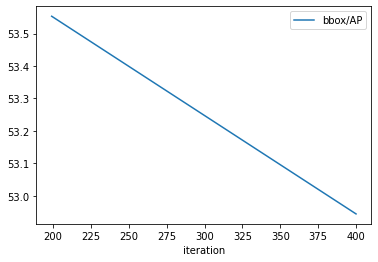

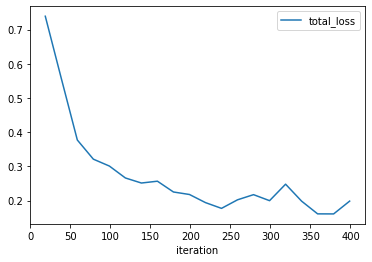

In [13]:
evaluation_df.plot('iteration', 'bbox/AP')
training_df.plot('iteration', 'total_loss')

##Using the trained model

###Inference

We want to use the trained neural network on images which it was not trained on. Below we create an inference predictor with weights from the trained model.

We then randomly select images from the validation dataset and perform inference on them.

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


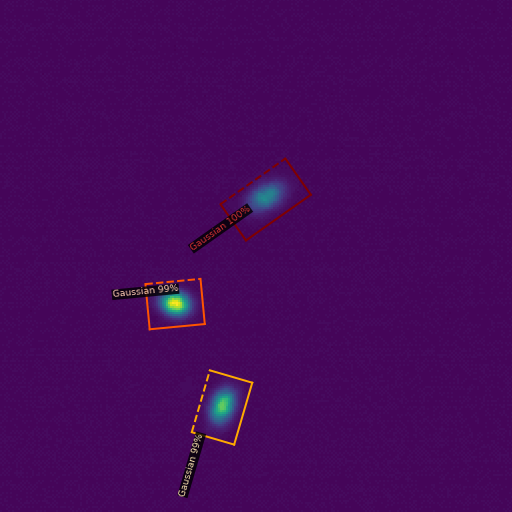

Ground Truth
[111.3404709878, 202.980323027, 33.3103304835, 21.9721727901, 67.6913644202]
[132.797821787, 98.8847139968, 36.7527400242, 23.299200384, 31.5336126219]
[87.6909797625, 151.8218808393, 28.2311770326, 22.1321486538, -14.7645189185]
Prediction
[132.82601928710938, 99.74774932861328, 39.660003662109375, 22.132003784179688, 35.151458740234375]
[87.54708099365234, 152.04483032226562, 27.663198471069336, 22.683170318603516, 5.4280242919921875]
[111.00814819335938, 203.73291015625, 32.2353401184082, 22.073162078857422, 73.70072937011719]


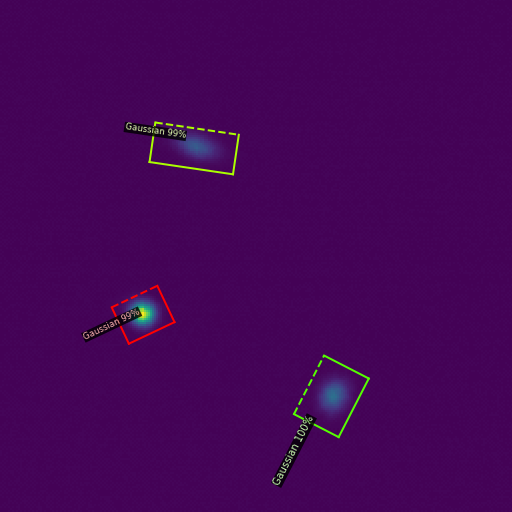

Ground Truth
[71.304322407, 156.835903998, 23.1072973149, 21.4928370033, -12.9582733597]
[166.3560267548, 197.8463544671, 30.8618159454, 25.6575317532, 65.3667287359]
[98.1350508691, 73.5894466156, 41.4751601775, 21.5184470304, -19.140897548]
Prediction
[165.68820190429688, 198.16004943847656, 32.93265914916992, 25.116872787475586, 62.79331970214844]
[97.08092498779297, 74.20584869384766, 42.186065673828125, 19.976015090942383, -8.351165771484375]
[71.55078125, 157.37486267089844, 25.22730827331543, 20.10041618347168, 25.310638427734375]


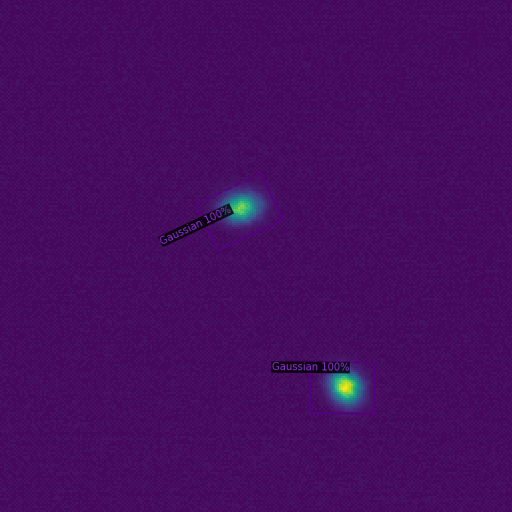

Ground Truth
[172.2035631822, 193.483512234, 32.9075091459, 27.9670883649, -55.1015468171]
[120.5086444551, 104.4081815827, 35.6483641884, 27.3837390204, 9.6710745384]
Prediction
[119.69254302978516, 105.95172882080078, 35.93526840209961, 25.574115753173828, 25.33038330078125]
[171.10107421875, 193.885498046875, 32.045982360839844, 25.50091552734375, -0.493682861328125]


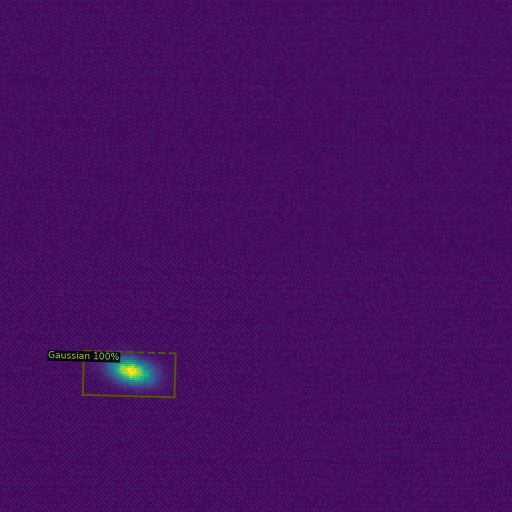

Ground Truth
[65.6765757962, 185.729909516, 43.2279716859, 23.5146147402, -14.472315061]
Prediction
[64.59337615966797, 187.07032775878906, 45.87770080566406, 21.93129539489746, -1.574462890625]


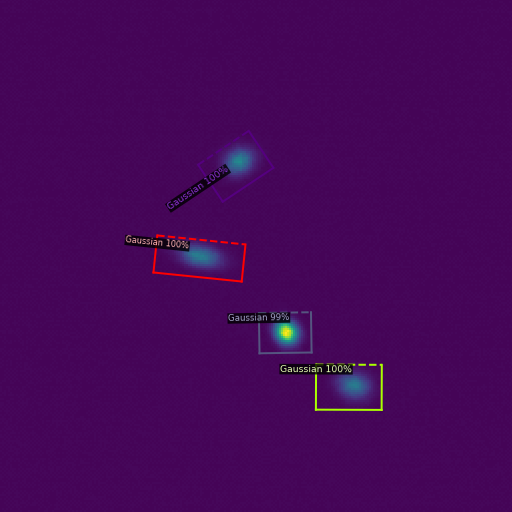

Ground Truth
[119.5716914239, 81.259952568, 29.6590069602, 24.0133748178, 29.5010049028]
[142.7323049549, 166.1511822267, 24.1735136166, 21.0773130672, -50.0235781359]
[176.507662438, 192.7204893783, 31.9611390177, 24.4932255648, -15.5665418654]
[100.0097449084, 128.3379099835, 41.6102584998, 19.7668715232, -12.259325606099999]
Prediction
[117.86632537841797, 83.16078186035156, 30.475553512573242, 22.20359230041504, 33.76689147949219]
[174.42176818847656, 193.62594604492188, 32.85926818847656, 22.540878295898438, -0.2175445556640625]
[99.73538208007812, 129.241943359375, 44.34674072265625, 18.613985061645508, -5.846649169921875]
[142.6180877685547, 166.3873748779297, 26.042049407958984, 20.1309757232666, 0.90447998046875]


In [14]:
from detectron2.engine import DefaultPredictor

def pred_abox_list(outputs):
  tensor_pred = outputs['instances'].get_fields()['pred_boxes'].tensor
  pred_list = tensor_pred.cpu().numpy().tolist()
  return pred_list
  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST =0.8
predictor = DefaultPredictor(cfg)

num_samples = 5
for d in random.sample(val_dataset_dicts, num_samples):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=val_dataset_metadata)
    outputs = predictor(img)
    v = Visualizer(img[:,:,::-1], val_dataset_metadata, scale=2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

    print('Ground Truth')
    [print(pobject['bbox']) for pobject in d['annotations']]
    print('Prediction')
    [print(box) for box in pred_abox_list(outputs)]